In [1]:
# package imports 
import polars as pl
from pathlib import Path

# Energy Data Analytics - Trading Analytics Example
This example should show, how in general trading analytics can be employed to develop a deeper understanding of the market and even find trading strategy. The model is based on the stack model discussed in class.

## Model Approach
Our approach here is the following: 
- Model the stack 
- Model the renewable forecast distribution at the day ahead auction 
- Combine the two to calculate a "fair" price, which we can then use to open positions on IDA1 and close them on intraday

## Stack Modelling
As we learned, to model the stack we need to know two attributes of each conventional power plant: The installed capacity and the marginal production costs.
Anyhow, Marginal production costs of conventional power plants are not generally known. To model the stack we will use the actual production data for each german power plant over one week and observe at which prices it was running, to find the marginal production costs.

In [13]:
# import data
data_dir = Path("Data/actual_production_per_plant")
csv_files = list(data_dir.glob("*.csv"))

In [14]:
# Import prices data
prices_df = pl.read_csv("Data/prices/prices2025.csv", null_values=["n/e", ""])

# Add datetime column by parsing the first part of "MTU (CET/CEST)"
prices_df = prices_df.with_columns(
    pl.col("MTU (CET/CEST)")
    .str.split(" - ")
    .list.get(0)
    .str.to_datetime(format="%d/%m/%Y %H:%M:%S")
    .alias("datetime")
)

# Resample to hourly resolution using average
prices_df = prices_df.group_by_dynamic(
    "datetime",
    every="1h"
).agg([
    pl.col("Day-ahead Price (EUR/MWh)").mean().alias("day_ahead_price"),
]).sort("datetime")

print(prices_df)

shape: (7_726, 2)
┌─────────────────────┬─────────────────┐
│ datetime            ┆ day_ahead_price │
│ ---                 ┆ ---             │
│ datetime[μs]        ┆ f64             │
╞═════════════════════╪═════════════════╡
│ 2025-01-01 00:00:00 ┆ 1.0225          │
│ 2025-01-01 01:00:00 ┆ 0.5425          │
│ 2025-01-01 02:00:00 ┆ -0.73875        │
│ 2025-01-01 03:00:00 ┆ -1.305          │
│ 2025-01-01 04:00:00 ┆ -3.255          │
│ …                   ┆ …               │
│ 2025-11-18 19:00:00 ┆ 127.5           │
│ 2025-11-18 20:00:00 ┆ 109.27375       │
│ 2025-11-18 21:00:00 ┆ 98.8925         │
│ 2025-11-18 22:00:00 ┆ 96.8725         │
│ 2025-11-18 23:00:00 ┆ 86.7975         │
└─────────────────────┴─────────────────┘


In [15]:
# Read and combine all CSV files
plant_production_df = pl.concat([pl.read_csv(file, null_values=["n/e", ""]) for file in csv_files])

# Add datetime column by parsing the first part of "Time Interval (CET/CEST)"
plant_production_df = plant_production_df.with_columns(
    pl.col("MTU (CET/CEST)")
    .str.split(" - ")
    .list.get(0)
    .str.to_datetime(format="%d/%m/%Y %H:%M")
    .alias("datetime")
)

# Select and rename columns, fill null values in generation
plant_production_df = plant_production_df.select([
    pl.col("datetime"),
    pl.col("Unit Name").alias("unit"),
    pl.col("Generation (MW)").fill_null(0).alias("generation")
])

# Join day_ahead_price to plant_production_df
plant_production_df = plant_production_df.join(
    prices_df.select(["datetime", "day_ahead_price"]),
    on="datetime",
    how="left"
)

print(plant_production_df)

shape: (17_808, 4)
┌─────────────────────┬────────────────────────┬────────────┬─────────────────┐
│ datetime            ┆ unit                   ┆ generation ┆ day_ahead_price │
│ ---                 ┆ ---                    ┆ ---        ┆ ---             │
│ datetime[μs]        ┆ str                    ┆ f64        ┆ f64             │
╞═════════════════════╪════════════════════════╪════════════╪═════════════════╡
│ 2025-11-03 00:00:00 ┆ GTHKW Nossener Bruecke ┆ 152.32     ┆ 76.40625        │
│ 2025-11-03 01:00:00 ┆ GTHKW Nossener Bruecke ┆ 152.35     ┆ 74.9625         │
│ 2025-11-03 02:00:00 ┆ GTHKW Nossener Bruecke ┆ 151.85     ┆ 71.265          │
│ 2025-11-03 03:00:00 ┆ GTHKW Nossener Bruecke ┆ 93.85      ┆ 70.38375        │
│ 2025-11-03 04:00:00 ┆ GTHKW Nossener Bruecke ┆ 151.72     ┆ 72.23125        │
│ …                   ┆ …                      ┆ …          ┆ …               │
│ 2025-11-09 19:00:00 ┆ RUHRORT-3              ┆ 0.0        ┆ 117.92875       │
│ 2025-11-09 20:00:00

In [16]:
# Get the marginal prices for each power plant
results = []

for unit_name in plant_production_df["unit"].unique():
    # Filter and sort by datetime
    unit_df = plant_production_df.filter(pl.col("unit") == unit_name).sort("datetime")

    #Round the generation of the power plant to the next 50MW to ignore small ramps etc
    unit_df = unit_df.with_columns(
        (pl.col("generation") / 50).ceil().mul(50).alias("generation")
    )
    
    # Skip if all generation values are zero
    if unit_df["generation"].max() == 0:
        continue

    # If all generation values are non-zero, marginal price is 0
    if unit_df["generation"].min() > 0:
        results.append({
            "unit": unit_name,
            "generation": unit_df["generation"].max(),
            "marginal_price": 0
        })
        continue
    
    # Create groups for consecutive non-zero generation periods
    # Mark where generation changes from 0 to non-zero or vice versa
    unit_df = unit_df.with_columns(
        (pl.col("generation") == 0).alias("is_zero")
    )
    
    # Create group ID that changes whenever we transition between 0 and non-zero
    unit_df = unit_df.with_columns(
        pl.col("is_zero").cum_sum().alias("group_id")
    )
    
    # Calculate average day_ahead_price for each group
    group_avg = unit_df.group_by("group_id").agg([
        pl.col("day_ahead_price").mean().alias("avg_price")
    ])

    # Join group_avg back to unit_df
    unit_df = unit_df.join(group_avg, on="group_id", how="left")
    
    unit_df = unit_df.filter(pl.col("generation")==pl.col("generation").max())
    
    results.append({
            "unit": unit_name,
            "generation": unit_df["generation"].max(),
            "marginal_price": unit_df["avg_price"].min()
        })

# Convert results to dataframe
marginal_results_df = pl.DataFrame(results)

# Sort by marginal_price and add cumulated generation column
marginal_results_df = marginal_results_df.sort("marginal_price").with_columns(
    pl.col("generation").cum_sum().alias("cumulated_generation")
)

print(marginal_results_df)

shape: (77, 4)
┌─────────────────────────┬────────────┬────────────────┬──────────────────────┐
│ unit                    ┆ generation ┆ marginal_price ┆ cumulated_generation │
│ ---                     ┆ ---        ┆ ---            ┆ ---                  │
│ str                     ┆ f64        ┆ f64            ┆ f64                  │
╞═════════════════════════╪════════════╪════════════════╪══════════════════════╡
│ Weisweiler G            ┆ 700.0      ┆ 0.0            ┆ 700.0                │
│ KW Boxberg Block P      ┆ 500.0      ┆ 0.0            ┆ 1200.0               │
│ KW Jänschwalde Block D  ┆ 500.0      ┆ 0.0            ┆ 1700.0               │
│ IKS Schwedt SE1 Block 1 ┆ 150.0      ┆ 0.0            ┆ 1850.0               │
│ KW Laufenburg           ┆ 100.0      ┆ 0.0            ┆ 1950.0               │
│ …                       ┆ …          ┆ …              ┆ …                    │
│ Weisweiler VGT - BI. G  ┆ 200.0      ┆ 117.10125      ┆ 28500.0              │
│ HKW Tiefsta

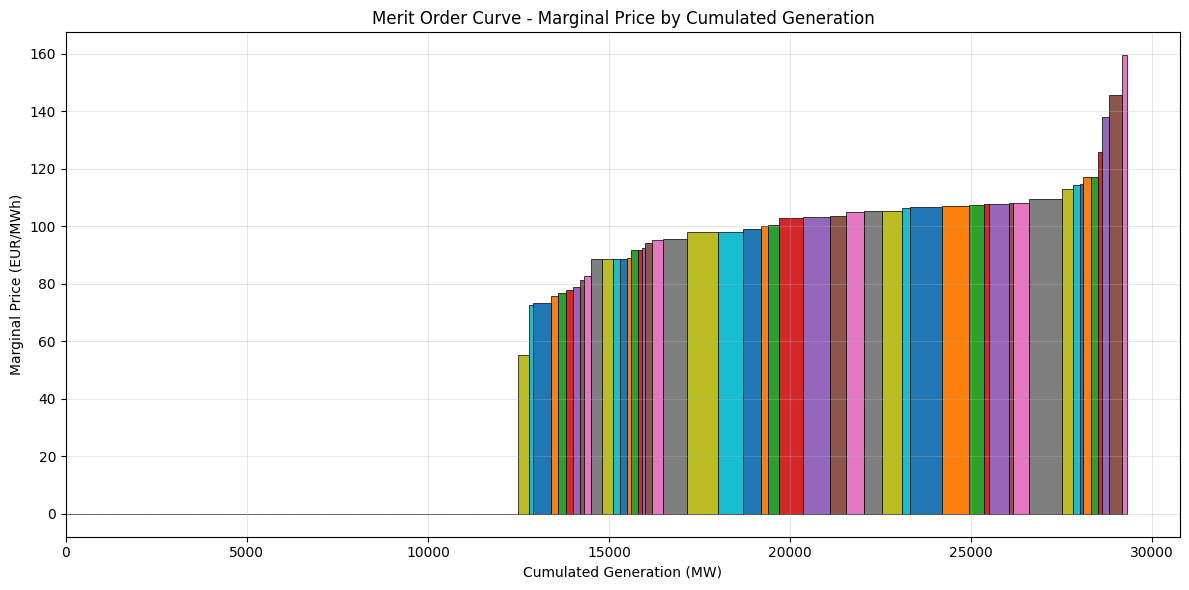

In [17]:
# Create a stacked bar chart
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

# Create bars for each unit
for i in range(len(marginal_results_df)):
    row = marginal_results_df.row(i, named=True)
    # Calculate the starting position (previous cumulated generation)
    x_start = row["cumulated_generation"] - row["generation"]
    
    ax.barh(
        y=row["marginal_price"] / 2,  # Center the bar at half the marginal price
        width=row["generation"],
        left=x_start,
        height=row["marginal_price"],  # Bar extends from 0 to marginal_price
        label=row["unit"],
        edgecolor='black',
        linewidth=0.5
    )

ax.set_xlabel("Cumulated Generation (MW)")
ax.set_ylabel("Marginal Price (EUR/MWh)")
ax.set_title("Merit Order Curve - Marginal Price by Cumulated Generation")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Renewable Forecast Error Analysis
Point forecasts are usefull and the industry standard, but getting probability distributions is often a powerful tool in power markets, as the price sensitivity of the stack is not symetrical. So to figure out if there is a bigger price movement for either under or over estimation, we first have to figure out how wrong our forecasts are in general. This can easily be calculated using historical forecast data and actuals, to see the distribution of the error (should be normal distributed if the forecast is not totally off).

In [ ]:
# import Data
